In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import wandb  # Optional: for experiment tracking
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


class PoetryLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, seq_length, num_layers=2, dropout=0.2):
        super(PoetryLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    
    def forward(self, x, hidden=None):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        output = self.fc(output[:, -1, :])  # Take only the last output
        return output, hidden

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    device,
    early_stopping=None,
    use_wandb=False
):
    """
    Enhanced training function with validation, early stopping, and learning rate scheduling
    
    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of training epochs
        device: Device to train on (cuda/cpu)
        early_stopping: EarlyStopping instance
        use_wandb: Whether to log metrics to Weights & Biases
    """
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_perplexity': [],
        'val_perplexity': []
    }
    
    # Move model to device
    model = model.to(device)
    
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0
        train_batches = 0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            train_batches += 1
            train_pbar.set_postfix({'loss': train_loss/train_batches})
        
        avg_train_loss = train_loss / train_batches
        train_perplexity = np.exp(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_batches = 0
        
        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                val_batches += 1
                val_pbar.set_postfix({'loss': val_loss/val_batches})
        
        avg_val_loss = val_loss / val_batches
        val_perplexity = np.exp(avg_val_loss)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_perplexity'].append(train_perplexity)
        history['val_perplexity'].append(val_perplexity)
        
        # Log metrics
        if use_wandb:
            wandb.log({
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_perplexity': train_perplexity,
                'val_perplexity': val_perplexity,
                'learning_rate': optimizer.param_groups[0]['lr']
            })
        
        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f'\nEpoch {epoch+1}/{num_epochs} - {epoch_time:.2f}s')
        print(f'Train Loss: {avg_train_loss:.4f} - Train Perplexity: {train_perplexity:.2f}')
        print(f'Val Loss: {avg_val_loss:.4f} - Val Perplexity: {val_perplexity:.2f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\n')
        
        # Early stopping
        if early_stopping is not None:
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                model.load_state_dict(early_stopping.best_model)
                break
    
    return model, history

def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot perplexity
    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'], label='Train')
    plt.plot(history['val_perplexity'], label='Validation')
    plt.title('Perplexity Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:

def prepare_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Extract poetry column
    poetry_lines = df["Poetry"].astype(str).tolist()
    
    # Tokenization
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(poetry_lines)
    total_words = len(tokenizer.word_index) + 1
    
    # Convert text to sequences
    input_sequences = []
    for line in poetry_lines:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            input_sequences.append(token_list[:i+1])
    
    # Pad sequences
    max_sequence_length = max([len(seq) for seq in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
    
    # Split into features (X) and labels (y)
    X = input_sequences[:, :-1]
    y = input_sequences[:, -1]
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    return X_tensor, y_tensor, tokenizer, total_words, max_sequence_length


def prepare_training(X_tensor, y_tensor, batch_size=32, val_split=0.1):
    """Prepare data for training"""
    # Create train/val split
    train_size = int((1 - val_split) * len(X_tensor))
    val_size = len(X_tensor) - train_size
    
    train_dataset, val_dataset = random_split(
        TensorDataset(X_tensor, y_tensor),
        [train_size, val_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader

def train_poetry_model(X_tensor, y_tensor, vocab_size, config=None):
    """Main training function with configuration"""
    if config is None:
        config = {
            'embedding_dim': 256,
            'hidden_dim': 512,
            'num_layers': 2,
            'dropout': 0.3,
            'batch_size': 64,
            'learning_rate': 0.001,
            'num_epochs': 30,
            'patience': 5,
            'use_wandb': False
        }
    
    # Prepare data
    train_loader, val_loader = prepare_training(
        X_tensor, y_tensor, 
        batch_size=config['batch_size']
    )
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PoetryLSTM(
        vocab_size=vocab_size,
        embedding_dim=config['embedding_dim'],
        hidden_dim=config['hidden_dim'],
        seq_length=X_tensor.shape[1],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )
    
    # Initialize training components
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=0.01
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )
    early_stopping = EarlyStopping(patience=config['patience'])
    
    # Initialize wandb if needed
    if config['use_wandb']:
        wandb.init(project="urdu-poetry-generator", config=config)
    
    # Train model
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        config['num_epochs'],
        device,
        early_stopping,
        config['use_wandb']
    )
    
    # Plot training history
    plot_training_history(history)
    
    return model, history



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/3 [Val]: 100%|██████████| 145/145 [00:07<00:00, 18.58it/s, loss=10]  



Epoch 1/3 - 204.55s
Train Loss: 24.4528 - Train Perplexity: 41658930555.97
Val Loss: 10.0018 - Val Perplexity: 22066.11
Learning Rate: 0.100000



Epoch 2/3 [Val]: 100%|██████████| 145/145 [00:07<00:00, 18.43it/s, loss=8.45]



Epoch 2/3 - 218.18s
Train Loss: 9.2709 - Train Perplexity: 10624.50
Val Loss: 8.4546 - Val Perplexity: 4696.49
Learning Rate: 0.100000



Epoch 3/3 [Val]: 100%|██████████| 145/145 [00:07<00:00, 18.39it/s, loss=8.35]



Epoch 3/3 - 218.20s
Train Loss: 8.5313 - Train Perplexity: 5070.92
Val Loss: 8.3531 - Val Perplexity: 4243.14
Learning Rate: 0.100000



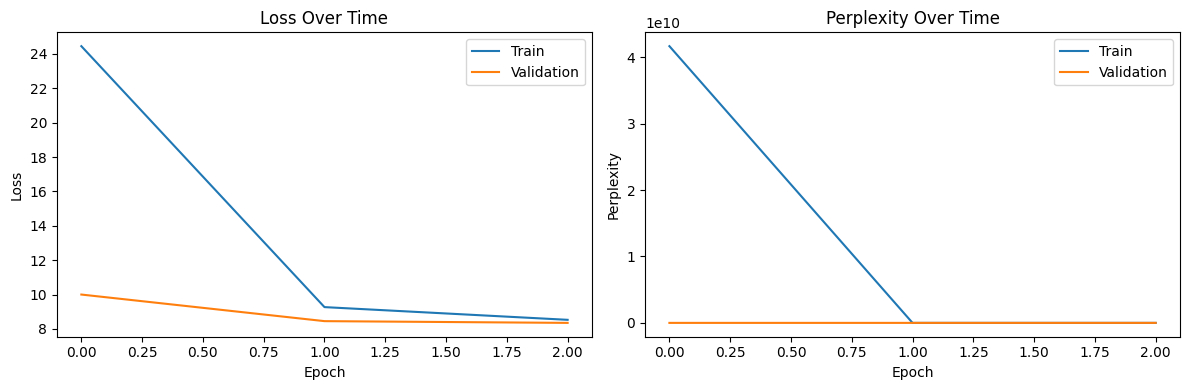

In [2]:
# Configure for faster training
config = {
    'embedding_dim': 128,    # Reduced dimension
    'hidden_dim': 256,      # Reduced dimension
    'num_layers': 1,        # Single layer
    'dropout': 0.2,         # Reduced dropout
    'batch_size': 128,      # Increased batch size
    'learning_rate': 0.1,  # Moderate learning rate
    'num_epochs': 3,        # Reduced epochs
    'patience': 2,          # Reduced patience
    'use_wandb': False
}

# Prepare the data and train
file_path = "/kaggle/input/romanurdudata/Roman-Urdu-Poetry.csv"  # Adjust this path as needed
X_tensor, y_tensor, tokenizer, total_words, max_sequence_length = prepare_data(file_path)

# Train the model
model, history = train_poetry_model(X_tensor, y_tensor, total_words, config)

In [3]:
import torch
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def save_model_and_config(model, tokenizer, config, save_dir="poetry_model"):
    """
    Save the model, tokenizer, and configuration
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model state
    torch.save(model.state_dict(), os.path.join(save_dir, "model_weights.pth"))
    
    # Save model configuration
    model_config = {
        "vocab_size": len(tokenizer.word_index) + 1,
        "embedding_dim": config['embedding_dim'],
        "hidden_dim": config['hidden_dim'],
        "num_layers": config['num_layers'],
        "dropout": config['dropout']
    }
    
    with open(os.path.join(save_dir, "model_config.json"), "w", encoding='utf-8') as f:
        json.dump(model_config, f, ensure_ascii=False, indent=4)
    
    # Save tokenizer configuration
    tokenizer_config = {
        "word_index": tokenizer.word_index,
        "index_word": tokenizer.index_word
    }
    
    with open(os.path.join(save_dir, "tokenizer_config.json"), "w", encoding='utf-8') as f:
        json.dump(tokenizer_config, f, ensure_ascii=False, indent=4)
    
    # Save training configuration
    with open(os.path.join(save_dir, "training_config.json"), "w", encoding='utf-8') as f:
        json.dump(config, f, ensure_ascii=False, indent=4)

def load_saved_model(save_dir="poetry_model"):
    """
    Load the saved model, tokenizer, and configurations
    """
    # Load model configuration
    with open(os.path.join(save_dir, "model_config.json"), "r", encoding='utf-8') as f:
        model_config = json.load(f)
    
    # Initialize model with saved configuration
    model = PoetryLSTM(
        vocab_size=model_config["vocab_size"],
        embedding_dim=model_config["embedding_dim"],
        hidden_dim=model_config["hidden_dim"],
        num_layers=model_config["num_layers"],
        dropout=model_config["dropout"],
        seq_length=None  # Will be determined during generation
    )
    
    # Load model weights
    model.load_state_dict(torch.load(os.path.join(save_dir, "model_weights.pth")))
    
    # Load tokenizer configuration
    with open(os.path.join(save_dir, "tokenizer_config.json"), "r", encoding='utf-8') as f:
        tokenizer_config = json.load(f)
    
    return model, tokenizer_config

def generate_poetry(model, tokenizer_config, seed_text, max_length=50, temperature=0.7):
    """
    Generate poetry with temperature-based sampling and improved output formatting
    
    Args:
        model: Loaded poetry model
        tokenizer_config: Loaded tokenizer configuration
        seed_text: Starting text for generation
        max_length: Maximum number of words to generate
        temperature: Controls randomness (higher = more creative)
    """
    model.eval()
    
    # Create reverse word index
    index_word = {int(k): v for k, v in tokenizer_config["index_word"].items()}
    word_index = tokenizer_config["word_index"]
    
    # Convert seed text to sequence
    words = seed_text.lower().split()
    current_sequence = [word_index.get(word, 1) for word in words]  # 1 is usually OOV token
    
    generated_words = words.copy()
    device = next(model.parameters()).device
    
    for _ in range(max_length):
        # Prepare input sequence
        padded_sequence = pad_sequences([current_sequence], maxlen=max(len(current_sequence), 1), padding='pre')
        input_tensor = torch.tensor(padded_sequence, dtype=torch.long).to(device)
        
        # Get model predictions
        with torch.no_grad():
            output, _ = model(input_tensor)
            
            # Apply temperature
            output = output / temperature
            
            # Convert to probabilities
            probs = torch.softmax(output[0], dim=-1)
            
            # Sample from the distribution
            predicted_index = torch.multinomial(probs, 1).item()
        
        # Get the predicted word
        predicted_word = index_word.get(predicted_index, "")
        
        if not predicted_word or predicted_word == "":
            continue
            
        generated_words.append(predicted_word)
        
        # Update current sequence
        current_sequence.append(predicted_index)
        if len(current_sequence) > max_length:
            current_sequence = current_sequence[1:]
    
    # Format the generated poetry
    return format_poetry(" ".join(generated_words))

def format_poetry(text, max_line_length=40):
    """
    Format the generated text into poetry-like structure
    """
    words = text.split()
    lines = []
    current_line = []
    current_length = 0
    
    for word in words:
        if current_length + len(word) + 1 > max_line_length:
            lines.append(" ".join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word) + 1
    
    if current_line:
        lines.append(" ".join(current_line))
    
    return "\n".join(lines)

In [4]:
# Save the model after training
save_model_and_config(model, tokenizer, config)

# Later, load the model and generate poetry
loaded_model, loaded_tokenizer = load_saved_model()

<ipython-input-3-7825183f862c>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, "model_weights.pth")))


In [5]:


# Generate poetry with different temperatures
seed_texts = [
    "dil ki baat",
    "zindagi ka safar",
    "mohabbat ka rang",
    "khushiyan aur gham"
]

print("\nGenerating poetry with different temperatures:")
temperatures = [0.5, 0.7, 1.0]

for seed_text in seed_texts:
    print(f"\nSeed Text: {seed_text}")
    for temp in temperatures:
        print(f"\nTemperature: {temp}")
        generated_poem = generate_poetry(
            loaded_model,
            loaded_tokenizer,
            seed_text,
            max_length=50,
            temperature=temp
        )
        print("Generated Poetry:")
        print("-" * 40)
        print(generated_poem)
        print("-" * 40)


Generating poetry with different temperatures:

Seed Text: dil ki baat

Temperature: 0.5
Generated Poetry:
----------------------------------------
dil ki baat hai e hai e hai e e e se
kyā bhī hai hai e kā e hai e e bhī haiñ
nahīñ e hai hai hai na kyā hai hai e kī
hai hai ko hai hai e e hai haiñ hai hai
e ke e e hai hai hai
----------------------------------------

Temperature: 0.7
Generated Poetry:
----------------------------------------
dil ki baat kahte e tum liye ke o hai e
jo kī hai hai bahut liye aaj husn aayā
nākām ho kabhī ko ye ki mujhe haiñ sab
ko ham kī hai e hai e se hai sar uljhā
huā har tak chashm e dīvār mujh se ho e
mirā hai kar
----------------------------------------

Temperature: 1.0
Generated Poetry:
----------------------------------------
dil ki baat qatra ko dil huuñ gunah
galiyoñ hī bachpan hī yāsman baith e gum
ġham thī kī lahza merā ḳhaak dīda bhare
liyā dekhiye meñ junūñ jo log ke e hameñ
dīvāne paḍī ugā jab hai hai na āb kī
bhar sun se baat le dekhe taraf 

In [7]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 100.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [9]:
import gradio as gr

# Load the model once before launching the app
loaded_model, loaded_tokenizer_config = load_saved_model()

# Gradio Interface
iface = gr.Interface(
    fn=lambda seed_text, max_length, temperature: generate_poetry(
        loaded_model, loaded_tokenizer_config, seed_text, max_length, temperature
    ),
    inputs=[
        gr.Textbox(label="Seed Text", placeholder="Enter starting words for poetry"),
        gr.Slider(10, 100, value=50, step=5, label="Max Words"),
        gr.Slider(0.5, 1.5, value=0.7, step=0.1, label="Creativity (Temperature)")
    ],
    outputs="text",
    title="Roman Urdu Poetry Generator",
    description="Generate Roman Urdu poetry using an LSTM model. Adjust word count and creativity for varied results."
)

if __name__ == "__main__":
    iface.launch()

<ipython-input-3-7825183f862c>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, "model_weights.pth")))


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://5f37b054311f744ec9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
